# AutoEncoder model 

### Loading the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import numpy as np

In [165]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

### Define the constants

In [7]:
DATA_SLICE_SIZE = 100
ANOMALY_INJECTION_SAMPLE_SIZE = 4000

In [2]:
def multiple_plotting(path_list):
    n_paths = len(path_list)
    data_df_list = []

    if n_paths == 0:
        print("Insert the correct paths!")

    # let last column vacant if the # of paths are odd
    vacant_col = n_paths % 2 != 0

    for path in path_list:
        data_df = pd.read_csv(path, header=None)
        data_df.columns = ['x', 'y', 'z']
        data_df_list.append(data_df)


    #################### Do not touch the logic
    n_rows = n_paths // 2
    if vacant_col:
        n_rows += 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(8, 2 * n_rows))


    for ax in axes.flatten():
        ax.set_ylim(0.6, 1.4)

    cur_df = 0

    # For edge case: only for one or two path list
    if n_paths <= 2:
        if not vacant_col:
            vector_value_2 = np.sqrt(data_df_list[1]['x']**2 + data_df_list[1]['y']**2 + data_df_list[1]['z']**2)
            axes[1].plot(vector_value_2)
        vector_value_1 = np.sqrt(data_df_list[0]['x']**2 + data_df_list[0]['y']**2 + data_df_list[0]['z']**2)
        axes[0].plot(vector_value_1)
        return

    # For Normal case: more than two path list
    for i in range(n_rows):
        for j in range(2):
            # Check whether last col should be vacant or not
            if i == n_paths // 2 and j == 1 and vacant_col:
                axes[i, j].axis('off')
                continue
            ##
            vector_value = np.sqrt(data_df_list[cur_df]['x']**2 + data_df_list[cur_df]['y']**2 + data_df_list[cur_df]['z']**2)
            axes[i, j].plot(vector_value)

            cur_df += 1
    ####################

    plt.show()

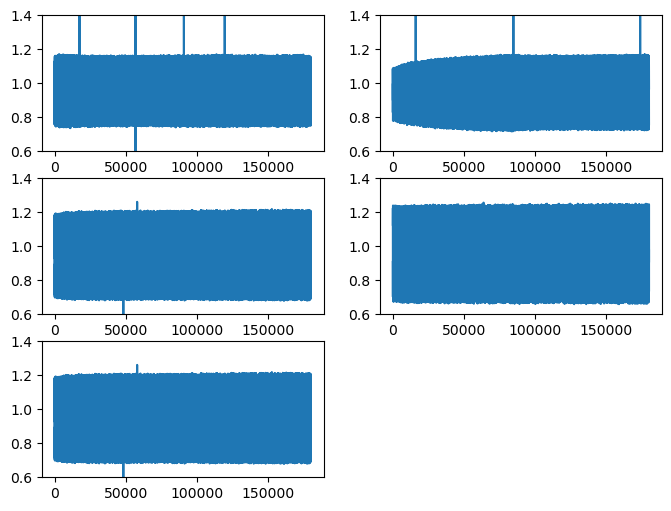

In [3]:
# Insert data paths in one list
multiple_plotting(['data/normal_9v_data.csv', 'data/normal_10v_data.csv',
                   'data/normal_11v_data.csv', 'data/normal_12v_data.csv',
                   'data/normal_11v_data.csv',])

In [8]:
import glob
file_paths = glob.glob('./data/anomaly_data/*.csv')

df_list = []

for file in file_paths:
    data_df = pd.read_csv(file, header=None)

    data_df = data_df[:ANOMALY_INJECTION_SAMPLE_SIZE]
    df_list.append(data_df)

anomaly_df = pd.concat(df_list, ignore_index=True)
anomaly_df.columns = ['x', 'y', 'z']

In [9]:
anomaly_df.shape

(40000, 3)

### Add normal datasets

In [4]:
data_normal_9v_df = pd.read_csv('data/normal_9v_data.csv', header=None)
data_normal_10v_df = pd.read_csv('data/normal_10v_data.csv', header=None)
data_normal_11v_df = pd.read_csv('data/normal_11v_data.csv', header=None)
data_normal_12v_df = pd.read_csv('data/normal_12v_data.csv', header=None)
data_normal_9v_common_noise_df = pd.read_csv('./data/normal_9v_common_noise_data.csv', header=None)
data_normal_9v_vibration_noise_df = pd.read_csv('./data/normal_9v_vibration_noise_data.csv', header=None)

# data_normal_9v_df = scaler.fit_transform(data_normal_9v_df)
# data_normal_10v_df = scaler.fit_transform(data_normal_10v_df)
# data_normal_11v_df = scaler.fit_transform(data_normal_11v_df)
# data_normal_12v_df = scaler.fit_transform(data_normal_12v_df)
# data_normal_9v_common_noise_df = scaler.fit_transform(data_normal_9v_common_noise_df)
# data_normal_9v_vibration_noise_df = scaler.fit_transform(data_normal_9v_vibration_noise_df)

combined_df = pd.concat([data_normal_9v_df, data_normal_10v_df,
                          data_normal_11v_df, data_normal_12v_df,
                          data_normal_9v_common_noise_df, data_normal_9v_vibration_noise_df], ignore_index=True)
print(combined_df.shape)

(960578, 3)


### Split data

In [113]:
import glob
train_ratio = 0.7
temp_ratio = 0.3  # for both val and test combined
val_ratio = 0.5  # 50% of temp_ratio for validation
test_ratio = temp_ratio / 2  # same as val_ratio

data_normal_12v_df = data_normal_12v_df[:len(data_normal_12v_df) - (len(data_normal_12v_df) % DATA_SLICE_SIZE)]
data_normal_9v_vibration_noise_df = data_normal_9v_vibration_noise_df[:len(data_normal_9v_vibration_noise_df) - (len(data_normal_9v_vibration_noise_df)% DATA_SLICE_SIZE)]
# print(len(data_normal_9v_df), len(data_normal_10v_df), len(data_normal_11v_df), len(data_normal_12v_df))
# print(data_normal_9v_df.shape, data_normal_10v_df.shape, data_normal_11v_df.shape, data_normal_12v_df.shape)

# print(data_normal_9v_df.shape)
# print(data_normal_10v_df.shape)
# print(data_normal_11v_df.shape)
# print(data_normal_12v_df.shape)
# print(data_normal_9v_common_noise_df.shape)
# print(data_normal_9v_vibration_noise_df.shape)


data_normal_9v_split = np.array_split(data_normal_9v_df, len(data_normal_9v_df) // DATA_SLICE_SIZE)
data_normal_10v_split = np.array_split(data_normal_10v_df, len(data_normal_10v_df) // DATA_SLICE_SIZE)
data_normal_11v_split = np.array_split(data_normal_11v_df, len(data_normal_11v_df) // DATA_SLICE_SIZE)
data_normal_12v_split = np.array_split(data_normal_12v_df, len(data_normal_12v_df) // DATA_SLICE_SIZE)
data_normal_9v_common_noise_split = np.array_split(data_normal_9v_common_noise_df, len(data_normal_9v_common_noise_df) // DATA_SLICE_SIZE)
data_normal_9v_vibration_noise_split = np.array_split(data_normal_9v_vibration_noise_df, len(data_normal_9v_common_noise_df) // DATA_SLICE_SIZE)


anomaly_file_paths = glob.glob('./data/anomaly_data/*.csv')

anomaly_splits = []
anomaly_splits_test = []
for i in anomaly_file_paths:
    data_df = pd.read_csv(file, header=None)
    # print(data_df.shape)
    data_df_quarter = data_df.iloc[:len(data_df) // 10] 
    data_df_split = np.array_split(data_df_quarter, len(data_df_quarter) // DATA_SLICE_SIZE)

    data_df_quarter_test = data_df.iloc[len(data_df) // 10:] 
    data_df_split_test = np.array_split(data_df_quarter_test, len(data_df_quarter_test) // DATA_SLICE_SIZE)

    anomaly_splits_test.append(data_df_split_test)
    anomaly_splits.append(data_df_split)
    # print(y_label_1_.shape)
    # print("aaa", len(data_df_split))

# print("anomaly shape ", anomaly_splits.shape)

data_splits = [data_normal_9v_split, data_normal_10v_split,
                data_normal_11v_split, data_normal_11v_split,
                data_normal_9v_common_noise_split,
                data_normal_9v_vibration_noise_split]

y_label_0_raw = []
y_label_1_raw = []
y_label_1_raw_test = []

for i in data_splits:
    print(len(i))
    y_label_0 = np.zeros(len(i))
    y_label_0_raw.append(y_label_0)

for i in anomaly_splits:
    # print(i.shape)
    y_label_1 = np.ones(len(i))
    y_label_1_raw.append(y_label_1)

for i in anomaly_splits_test:
    # print(i.shape)
    y_label_1_test = np.ones(len(i))
    y_label_1_raw_test.append(y_label_1_test)

anomaly_splits_test_raw = np.concatenate(anomaly_splits_test, axis = 0)


y_label_0_raw = np.concatenate(y_label_0_raw, axis=0)
y_label_1_raw = np.concatenate(y_label_1_raw, axis=0)
y_label_1_raw_test = np.concatenate(y_label_1_raw_test, axis=0)
print(len(y_label_0_raw), len(y_label_1_raw), len(y_label_1_raw_test))



y_label_raw = np.concatenate((y_label_0_raw, y_label_1_raw), axis = 0)
print(y_label_raw.shape)
data_splits.extend(anomaly_splits)
# print(len(anomaly_splits), len(data_splits))

train_sizes = []
train_data = []
val_data = []
test_data = []

y_train_data = []
y_val_data = []
y_test_data = []
start_idx = 0

for i in range(len(data_splits)):
    data_len = len(data_splits[i])
    train_size = int(data_len * train_ratio)
    temp_size = data_len - train_size 
    val_size = int(temp_size * val_ratio)
    
    # Split the data
    train_sizes.append(train_size)
    train_data.append(data_splits[i][:train_size])
    val_data.append(data_splits[i][train_size:train_size + val_size])
    test_data.append(data_splits[i][train_size + val_size:])

    y_train_data.append(y_label_raw[start_idx:start_idx + train_size])
    y_val_data.append(y_label_raw[start_idx + train_size:start_idx + train_size + val_size])
    y_test_data.append(y_label_raw[start_idx + train_size + val_size:start_idx + data_len])

    start_idx += data_len



# print("ddd", len(train_data[-1][-1]), len(val_data[-1][-1]),  len(test_data[-1][-1]))

# check the lengths of each split
for i in range(len(data_splits)):
    print(f"Data split {i}: train + val + test =", len(train_data[i]), "+", len(val_data[i]), "+", len(test_data[i]))
    print(len(train_data[i][0]), len(val_data[i][0]),  len(test_data[i][0]))

# Concatenate all splits across the normal datasets
x_train_concat = np.concatenate(train_data, axis=0)
x_val_concat = np.concatenate(val_data, axis=0)
x_test_concat = np.concatenate(test_data, axis=0)

y_train_concat = np.concatenate(y_train_data, axis=0)
y_val_concat = np.concatenate(y_val_data, axis=0)
y_test_concat = np.concatenate(y_test_data, axis=0)

# Output shapes to assure correct shape
print("Train data shape:", x_train_concat.shape)
print("Validation data shape:", x_val_concat.shape)
print("Test data shape:", x_test_concat.shape)

print("Train data shape:", y_train_concat.shape)
print("Validation data shape:", y_val_concat.shape)
print("Test data shape:", y_test_concat.shape)


print("anomaly_splits_test_raw.shape ", anomaly_splits_test_raw.shape, y_label_1_raw_test.shape)



/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future v

1800
1800
1800
1800
1200
1200
9600 1800 16200
(11400,)
Data split 0: train + val + test = 1260 + 270 + 270
100 100 100
Data split 1: train + val + test = 1260 + 270 + 270
100 100 100
Data split 2: train + val + test = 1260 + 270 + 270
100 100 100
Data split 3: train + val + test = 1260 + 270 + 270
100 100 100
Data split 4: train + val + test = 840 + 180 + 180
100 100 100
Data split 5: train + val + test = 840 + 180 + 180
100 100 100
Data split 6: train + val + test = 125 + 27 + 28
100 100 100
Data split 7: train + val + test = 125 + 27 + 28
100 100 100
Data split 8: train + val + test = 125 + 27 + 28
100 100 100
Data split 9: train + val + test = 125 + 27 + 28
100 100 100
Data split 10: train + val + test = 125 + 27 + 28
100 100 100
Data split 11: train + val + test = 125 + 27 + 28
100 100 100
Data split 12: train + val + test = 125 + 27 + 28
100 100 100
Data split 13: train + val + test = 125 + 27 + 28
100 100 100
Data split 14: train + val + test = 125 + 27 + 28
100 100 100
Data spli

In [115]:
from keras.utils import to_categorical

# Convert y_train and y_valid to one-hot encoding
y_train_one_hot = to_categorical(y_train_concat, num_classes=2)  # Assuming classes are 0, 1
y_valid_one_hot = to_categorical(y_val_concat, num_classes=2)  # Assuming you have a similar y_valid
y_test_one_hot = to_categorical(y_test_concat, num_classes=2)  # Assuming you have a similar y_test

# Check the shape
print(y_train_one_hot.shape)  # Should be (10070, 4)
print(y_valid_one_hot.shape) 
print(y_test_one_hot.shape) 

(7970, 2)
(1710, 2)
(1720, 2)


In [116]:
# Sum along axis 0 to get the count of each class
class_counts = np.sum(y_train_one_hot, axis=0)

# Calculate the percentage of each class
class_ratios = class_counts / np.sum(class_counts)

# Print the results
for i, (count, ratio) in enumerate(zip(class_counts, class_ratios)):
    print(f"Class {i}: count = {int(count)}, ratio = {ratio:.2%}")

Class 0: count = 6720, ratio = 84.32%
Class 1: count = 1250, ratio = 15.68%


In [117]:
import tensorflow as tf
import keras
from keras.layers import LSTM, Dropout, Dense, InputLayer
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [168]:
model = keras.models.Sequential([
    # Conv Block 1 
    keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu",
                        input_shape=[100, 3]),
    keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"), 

    # Pooling layer
    keras.layers.MaxPooling1D(pool_size=2),

    # Conv Block 2 
    keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"),
    keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"),           
    
    # Pooling layer
    keras.layers.MaxPooling1D(pool_size=2),  

    # Conv Block 3
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"),
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"),   
    
    # Pooling layer        
    keras.layers.MaxPooling1D(pool_size=2),  

    # Conv Block 4
    # keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),

    keras.layers.GlobalAveragePooling1D(),

    # Updated output layer for multi-class classification
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")  
])

# Compile the model
model.compile(loss="binary_crossentropy",  # Use categorical crossentropy
              optimizer="adam",
              metrics=["accuracy"])  # Accuracy metric is still appropriate

# # Train the model
# history = model.fit(
#     x_train_concat, y_train_one_hot,  # Ensure y_train is one-hot encoded for multi-class
#     epochs=20,  
#     batch_size=32,
#     validation_data=(x_val_concat, y_valid_one_hot),
#     verbose=1,
#     # class_weight=class_weights_dict,
#     # callbacks=[early_stop]
# )

# # Get predictions
# y_pred = model.predict(x_test_concat)
# y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Train the model
history = model.fit(
    x_train_concat, y_train_concat,  # Ensure y_train is one-hot encoded for multi-class
    epochs=10,  
    batch_size=32,
    validation_data=(x_val_concat, y_val_concat),
    verbose=1,
    # class_weight=class_weights_dict,
    # callbacks=[early_stop]
)

# Get predictions
y_pred = model.predict(x_test_concat)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# # Save the model
model.save("conv_net_new_data_anomaly_15p.h5")


Epoch 1/10


/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9113 - loss: 0.2576 - val_accuracy: 1.0000 - val_loss: 4.8395e-06
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.8366e-07
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 1.5875e-06 - val_accuracy: 1.0000 - val_loss: 1.9759e-08
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 2.9935e-07 - val_accuracy: 1.0000 - val_loss: 1.2800e-08
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 1.2969e-07 - val_accuracy: 1.0000 - val_loss: 1.1189e-08
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 7.2913e-08 - val_accuracy: 1.0000 - val_loss: 1.0608e-08
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 1.0000 - loss: 4.9250e-08 - val_accuracy: 1.0000 - val_loss: 1.0342e-08
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0

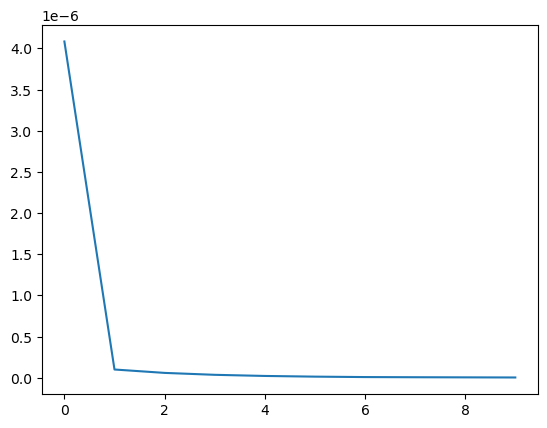

In [119]:

plt.plot(history.history["val_loss"])

In [120]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 100, 32)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 100, 32)        │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_51 (Conv1D)              │ (None, 50, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 25, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,829 (1.29 MB)

 Trainable params: 112,609 (439.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 225,220 (879.77 KB)

In [122]:
loss, accuracy = model.evaluate(x_test_concat, y_test_concat, verbose=1)
print(loss)
print(accuracy)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 1.9173e-09
2.58273114006613e-09
1.0


In [121]:
loss, accuracy = model.evaluate(anomaly_splits_test_raw, y_label_1_raw_test, verbose=1)
print(loss)
print(accuracy)

507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 1.7225e-10
1.9371136639190212e-10
1.0


In [171]:
y_pred = model.predict(anomaly_splits_test_raw, verbose=1)

print(y_pred[:10])
print(y_label_1_raw_test[:10])

507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [174]:
y_pred = model.predict(x_test_concat, verbose=1)

print(y_pred[:10])
print(y_test_concat[:10])

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[9.9731541e-01 6.2370417e-04 2.0609689e-03]
 [9.9957550e-01 1.0131643e-04 3.2326195e-04]
 [9.3877333e-01 3.9682076e-03 5.7258498e-02]
 [9.6514094e-01 1.8984770e-03 3.2960553e-02]
 [9.9768603e-01 4.1098875e-04 1.9029751e-03]
 [9.9929160e-01 1.6895907e-04 5.3948828e-04]
 [9.9943495e-01 1.0805808e-04 4.5704952e-04]
 [7.2029099e-02 1.4383234e-02 9.1358769e-01]
 [3.5445338e-01 1.6174611e-02 6.2937194e-01]
 [8.1945711e-01 1.2141216e-02 1.6840173e-01]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [72]:
import numpy as np

# y_pred의 형태 확인 및 정수형으로 변환
if y_pred.ndim == 2:
    y_pred = np.argmax(y_pred, axis=1)
elif y_pred.ndim == 1:
    print("y_pred는 이미 클래스 인덱스입니다.")

# y_test 및 y_pred의 고유 클래스 추출
unique_classes = np.unique(np.concatenate((y_test_concat, y_pred)))  # 두 배열의 고유 클래스 합치기

# 클래스 인덱스를 0부터 시작하도록 조정
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
y_test_mapped = np.array([class_to_index[cls] for cls in y_test_concat])
y_pred_mapped = np.array([class_to_index[cls] for cls in y_pred])


print(len(y_test_mapped))
print(len(y_pred_mapped))
# 혼동 행렬 초기화
num_classes = len(unique_classes)
conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

# 혼동 행렬 계산
for i in range(len(y_test_concat)):
    conf_matrix[y_test_mapped[i], y_pred_mapped[i]] += 1

# 혼동 행렬 출력
print("혼동 행렬:\n", conf_matrix)

4140
4140
혼동 행렬:
 [[1440    0]
 [   0 2700]]


In [105]:
## v1 - 
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test_concat)

y_pred_labels = (y_pred > 0.5).astype(int)
# y_test_labels = np.argmax(y_test_concat, axis=1) 
print(y_pred_labels.shape, y_test_concat.shape)

print(classification_report(y_test_concat, y_pred_labels))

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(2120, 1) (2120,)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1440
         1.0       1.00      1.00      1.00       680

    accuracy                           1.00      2120
   macro avg       1.00      1.00      1.00      2120
weighted avg       1.00      1.00      1.00      2120



### Classification with anomaly data

In [150]:
import glob
file_paths = glob.glob('./data/anomaly_data/*.csv')
exclude_files = [
    './data/anomaly_data/anomaly_7v_data2.csv',
    './data/anomaly_data/anomaly_7v_data1.csv'
]

file_paths = [file for file in file_paths if file not in exclude_files]

# df_list = []

# anomaly_splits = []
# for i in anomaly_file_paths:
#     data_df = pd.read_csv(file, header=None)

#     data_df_split_test = np.array_split(data_df, len(data_df) // DATA_SLICE_SIZE)
#     print(len(data_df_split_test))

#     anomaly_splits_test.append(data_df_split_test)
#     anomaly_splits.append(data_df_split)



In [157]:
labels = {
    '5v': 0,
    '3v': 0,
    'contact': 1,
    'unbalanced': 2
}

y_label_raw = []  

anomaly_splits = []


for file in file_paths:
    data_df = pd.read_csv(file, header=None)
    print(file)
    data_df = data_df[:len(data_df) - (len(data_df) % DATA_SLICE_SIZE)]

    data_df_split_test = np.array_split(data_df, len(data_df) // DATA_SLICE_SIZE)
    # print(len(data_df_split_test))

    
    for split in data_df_split_test:
        
        for key in labels.keys():
            if key in file:
                y_label = labels[key]
                break
        y_label_raw.append(y_label) 
        # print(split.shape, y_label)

    anomaly_splits.append(data_df_split_test)


y_label = np.array(y_label_raw)
x_concat = np.concatenate(anomaly_splits, axis = 0)

print(f"Labels: {y_label.shape}")
print(x_concat.shape)



./data/anomaly_data/anomaly_5v_data2.csv
./data/anomaly_data/anomaly_5v_data1.csv
./data/anomaly_data/anomaly_unbalanced_9v_data1.csv


/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


./data/anomaly_data/anomaly_3v_data1.csv
./data/anomaly_data/anomaly_3v_data2.csv


/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


./data/anomaly_data/anomaly_unbalanced_12v_data1.csv
./data/anomaly_data/anomaly_contact_12v_data1.csv
./data/anomaly_data/anomaly_contact_9v_data1.csv


/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Labels: (14400,)
(14400, 100, 3)


In [158]:
unique, counts = np.unique(y_label, return_counts=True)
label_counts = dict(zip(unique, counts))

# 전체 개수 계산
total_count = len(y_label)

# 라벨 비율 계산
label_ratios = {label: count / total_count for label, count in label_counts.items()}

# 결과 출력
print("Label counts:", label_counts)
print("Label ratios:", label_ratios)

Label counts: {0: 7200, 1: 3600, 2: 3600}
Label ratios: {0: 0.5, 1: 0.25, 2: 0.25}


In [159]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x_concat, y_label, test_size=0.3, random_state=42, stratify=y_label)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Test set:", x_test.shape, y_test.shape)

Training set: (10080, 100, 3) (10080,)
Validation set: (2160, 100, 3) (2160,)
Test set: (2160, 100, 3) (2160,)


In [160]:
from keras.utils import to_categorical

# Convert y_train and y_valid to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=3)  # Assuming classes are 0, 1
y_valid_one_hot = to_categorical(y_val, num_classes=3)  # Assuming you have a similar y_valid
y_test_one_hot = to_categorical(y_test, num_classes=3)  # Assuming you have a similar y_test

# Check the shape
print(y_train_one_hot.shape)  # Should be (10070, 4)
print(y_valid_one_hot.shape) 
print(y_test_one_hot.shape) 

(10080, 3)
(2160, 3)
(2160, 3)


In [172]:
model = keras.models.Sequential([
    # Conv Block 1 
    keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu",
                        input_shape=[100, 3]),
    keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"), 

    # Pooling layer
    keras.layers.MaxPooling1D(pool_size=2),

    # Conv Block 2 
    keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"),
    keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"),           
    
    # Pooling layer
    keras.layers.MaxPooling1D(pool_size=2),  

    # Conv Block 3
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"),
    keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"),   
    
    # Pooling layer        
    keras.layers.MaxPooling1D(pool_size=2),  

    # Conv Block 4
    # keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu"),

    keras.layers.GlobalAveragePooling1D(),

    # Updated output layer for multi-class classification
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(3, activation="softmax")  # Change to 4 units and softmax activation
])

# Compile the model
model.compile(loss="categorical_crossentropy",  # Use categorical crossentropy
              optimizer="adam",
              metrics=["accuracy"])  # Accuracy metric is still appropriate

# Train the model
history = model.fit(
    x_train, y_train_one_hot,  # Ensure y_train is one-hot encoded for multi-class
    epochs=20,  
    batch_size=32,
    validation_data=(x_val, y_valid_one_hot),
    verbose=1,
    # class_weight=class_weights_dict,
    # callbacks=[early_stop]
)

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# # Save the model
model.save("conv_net_classification_1.h5")


Epoch 1/20


/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7709 - loss: 0.5072 - val_accuracy: 0.9630 - val_loss: 0.0920
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9501 - loss: 0.1408 - val_accuracy: 0.9861 - val_loss: 0.0432
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9670 - loss: 0.0912 - val_accuracy: 0.9755 - val_loss: 0.0590
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9793 - loss: 0.0634 - val_accuracy: 0.9954 - val_loss: 0.0216
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9849 - loss: 0.0409 - val_accuracy: 0.9986 - val_loss: 0.0079
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9929 - loss: 0.0201 - val_accuracy: 0.9991 - val_loss: 0.0028
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9920 - loss: 0.0280 - val_accuracy: 0.9995 - val_loss: 0.0052
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9982 - loss: 0.0053 - val_accuracy: 0.9986 - val_

In [173]:
## v1 - 
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test)

y_pred_labels = (y_pred > 0.5).astype(int)
# y_test_labels = np.argmax(y_test_concat, axis=1) 
print(y_pred_labels.shape, y_test_one_hot.shape)

print(classification_report(y_test_one_hot, y_pred_labels))

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(2160, 3) (2160, 3)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1080
           1       1.00      1.00      1.00       540
           2       1.00      1.00      1.00       540

   micro avg       1.00      1.00      1.00      2160
   macro avg       1.00      1.00      1.00      2160
weighted avg       1.00      1.00      1.00      2160
 samples avg       1.00      1.00      1.00      2160



In [170]:
import tensorflow as tf
import numpy as np

# .h5 모델 로드
h5_model = tf.keras.models.load_model('conv_net_classification_1.h5')

# .tflite 변환기 생성
converter = tf.lite.TFLiteConverter.from_keras_model(h5_model)

# 양자화 적용 (정수 양자화)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter._experimental_disable_per_channel_quantization_for_dense_layers = True

# INT8 양자화를 위해 필요한 대표적인 데이터셋 함수 정의
def representative_dataset():
    for i in range(100):  # 임의로 100개의 샘플을 사용
        # X_windows_balanced에서 일부 샘플을 선택
        sample = x_train[i]  # 각 sample의 shape은 (10, 3)
        # shape을 (1, 10, 3)로 맞추기 위해 배치 차원 추가
        yield [np.expand_dims(sample, axis=0).astype(np.float32)]

# # INT8 양자화를 위해 필요한 대표적인 데이터셋 함수 정의
# def representative_dataset():
#     for _ in range(100):
#         # (1, 10, 24)은 배치 크기 1, 10x24 크기의 입력 데이터를 의미합니다.
#         yield [np.random.rand(1, 10, 24).astype(np.float32)]

# # 대표 데이터셋 지정
converter.representative_dataset = representative_dataset

# 완전한 INT8 양자화를 위한 설정
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]  # INT8 연산만 허용
converter.inference_input_type = tf.int8  # 입력 타입을 INT8로 설정
converter.inference_output_type = tf.int8  # 출력 타입을 INT8로 설정


# .tflite 모델로 변환
tflite_model = converter.convert()

# .tflite 모델 저장
with open('conv_net_classification_1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/lx/t6fh69qs69d9s21bvsl3_ynr0000gn/T/tmpv_sjvkhn/assets


INFO:tensorflow:Assets written to: /var/folders/lx/t6fh69qs69d9s21bvsl3_ynr0000gn/T/tmpv_sjvkhn/assets


Saved artifact at '/var/folders/lx/t6fh69qs69d9s21bvsl3_ynr0000gn/T/tmpv_sjvkhn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 3), dtype=tf.float32, name='input_layer_9')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  11206710848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206714896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206575728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206577840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206585232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206588224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206589456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206904640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206908864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206911152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11206913088: T

/Users/seyeong/anaconda3/envs/anomaly_detection/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1728914751.759401  744720 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1728914751.759421  744720 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-10-14 23:05:51.759525: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/lx/t6fh69qs69d9s21bvsl3_ynr0000gn/T/tmpv_sjvkhn
2024-10-14 23:05:51.760286: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-10-14 23:05:51.760291: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/lx/t6fh69qs69d9s21bvsl3_ynr0000gn/T/tmpv_sjvkhn
2024-10-14 23:05:51.766291: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-10-14 23:05:51.797